In [1]:
## the forcing for SWMM will be generated in this notebook


# import the required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import geopandas as gpd



In [2]:

chirps_nc_path = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\Wflow - WitteveenBos\wflow_JMS\HydroMT\Nakuru_res0.002dg_complete_chirps\inmaps_chirps_Nakuru_86400_2007_2021.nc"
#chirps_nc_path = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\Wflow - WitteveenBos\wflow_JMS\HydroMT\Nakuru_res0.002dg_complete_chirps\2025-05-22 CC\Nakuru_res0.002dg_complete_chirps\inmaps_chirps_Nakuru_86400_2007_2021_cc_ext.nc"
chirps_data = xr.open_dataset(chirps_nc_path)

display(chirps_data)

<xarray.Dataset> Size: 5GB
Dimensions:      (time: 5479, longitude: 233, latitude: 321)
Coordinates:
  * time         (time) datetime64[ns] 44kB 2007-01-01 2007-01-02 ... 2021-12-31
  * longitude    (longitude) float64 2kB 35.84 35.84 35.84 ... 36.22 36.22 36.22
  * latitude     (latitude) float64 3kB -0.1821 -0.1838 ... -0.7138 -0.7154
    spatial_ref  int32 4B ...
Data variables:
    precip       (time, latitude, longitude) float32 2GB ...
    pet          (time, latitude, longitude) float32 2GB ...
    temp         (time, latitude, longitude) float32 2GB ...
Attributes:
    standard_name:  precipitation
    units:          mm
    _FillValue:     nan
    unit:           mm
    precip_fn:      chirps_global

In [3]:
df_chrips = chirps_data.mean(dim=['latitude', 'longitude']).to_dataframe()

total_precip_mm = df_chrips[df_chrips['precip'] >0].sum()
print(f"Total precipitation in mm: {total_precip_mm}")

import scipy.stats as stats

# df_chrips should have a datetime index and a 'precip' column (catchment average)
df_chrips['year'] = pd.to_datetime(df_chrips.index).year

# Get annual maxima for each year
annual_maxima_catchment = df_chrips.groupby('year')['precip'].max()
print(annual_maxima_catchment)

# Fit Gumbel distribution
# params_catchment = stats.gumbel_r.fit(annual_maxima_catchment)

# # Calculate the 50-year return period precipitation
# prob_50 = 1 - (1/50)
# precip_50yr_catchment = stats.gumbel_r.ppf(prob_50, *params_catchment)

# print(f"50-year return period daily precipitation (whole catchment average): {precip_50yr_catchment:.2f} mm")

# # Calculate yearly total precipitation (whole catchment average)
# df_chrips['year'] = pd.to_datetime(df_chrips.index).year
# yearly_total_precip = df_chrips.groupby('year')['precip'].sum()

# print("Yearly total precipitation (mm):")
# print(yearly_total_precip.round(2))

# # Mean of yearly totals
# mean_yearly_total = yearly_total_precip.mean()
# print(f"\nMean of yearly total precipitation: {mean_yearly_total:.2f} mm")

Total precipitation in mm: precip         16025.210938
pet             7826.701660
temp           39616.078125
spatial_ref        0.000000
dtype: float64
year
2007    49.492252
2008    28.721807
2009    34.684013
2010    36.557121
2011    46.835655
2012    40.284863
2013    45.069145
2014    44.820042
2015    33.484695
2016    40.195145
2017    35.964474
2018    47.423344
2019    36.152939
2020    55.592068
2021    48.126812
Name: precip, dtype: float32


<Axes: >

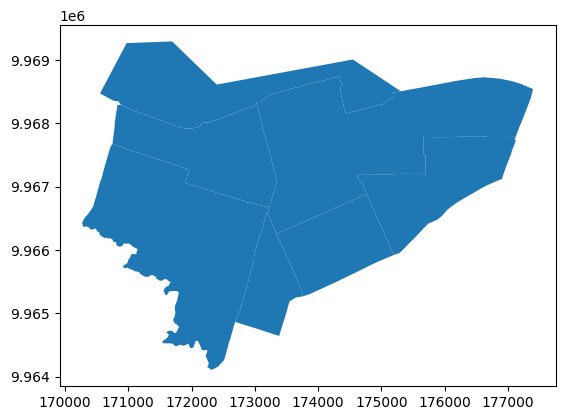

In [4]:
shapefile_path = r"C:\Users\jmsch\OneDrive\Documenten\Studie\Civiele Techniek\Environmental Engineering\Year 2\Afstuderen\NBS Nakuru Kenia\2. QGIS + Wflow\SWMM\SWD network\New_boundary_swd_dem.gpkg"

boundary = gpd.read_file(shapefile_path)

boundary.plot()

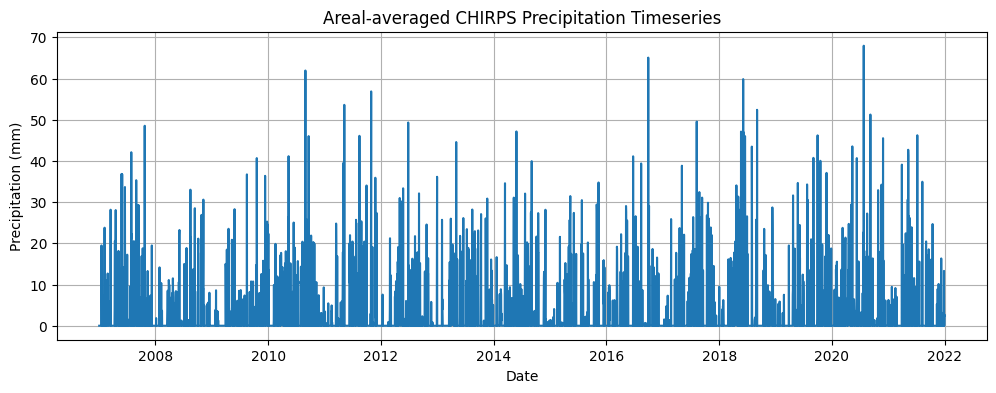

,time,spatial_ref,precip
0,2007-01-01,0,NaN
1,2007-01-02,0,0.000000
2,2007-01-03,0,0.000000
3,2007-01-04,0,0.000000
4,2007-01-05,0,0.000000
...,...,...,...
5474,2021-12-27,0,13.303743
5475,2021-12-28,0,0.000000
5476,2021-12-29,0,0.000000
5477,2021-12-30,0,2.696650


In [5]:
import rasterio
import rioxarray
from shapely.geometry import mapping

# Ensure chirps_data is georeferenced
chirps_data = chirps_data.rio.write_crs("EPSG:4326", inplace=True)

# Reproject boundary to match CHIRPS data CRS if needed
if boundary.crs != chirps_data.rio.crs:
    boundary = boundary.to_crs(chirps_data.rio.crs)

# Clip CHIRPS data to the boundary
clipped = chirps_data.rio.clip(boundary.geometry.apply(mapping), boundary.crs, drop=True)

# Compute the spatial mean (average over area) for each timestep
# Replace 'precip' with the actual variable name in your dataset if different
precip_var = list(clipped.data_vars)[0]  # e.g., 'precip'
timeseries = clipped[precip_var].mean(dim=['latitude', 'longitude'])

# Convert to DataFrame for easier handling
df_timeseries = timeseries.to_dataframe().reset_index()


# Plot the timeseries
plt.figure(figsize=(12, 4))
plt.plot(df_timeseries['time'], df_timeseries[precip_var])
plt.title('Areal-averaged CHIRPS Precipitation Timeseries')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

display(df_timeseries)

In [6]:
import scipy.stats as stats

# Assume df_timeseries['time'] is datetime and df_timeseries[precip_var] is daily rainfall in mm
df_timeseries['year'] = pd.to_datetime(df_timeseries['time']).dt.year

# Calculate yearly total precipitation (whole catchment average)
yearly_total_precip_clip = df_timeseries.groupby('year')['precip'].sum()

print("Yearly total precipitation (mm):")
print(yearly_total_precip_clip.round(2))

# Mean of yearly totals
mean_yearly_total_clip = yearly_total_precip_clip.mean()
print(f"\nMean of yearly total precipitation: {mean_yearly_total_clip:.2f} mm")

# # Get annual maxima
# annual_maxima = df_timeseries.groupby('year')[precip_var].max().dropna()
# print("Annual maxima (mm):")
# print(annual_maxima.round(2))

# # Fit Gumbel distribution (extreme value type I)
# params = stats.gumbel_r.fit(annual_maxima)

# # Return periods
# return_periods = [2, 5, 10, 30, 50, 100]
# probabilities = [1 - 1/t for t in return_periods]

# # Calculate quantiles for each return period
# rainfall_return_levels = stats.gumbel_r.ppf(probabilities, *params)

# Only use days with precip > 0 for annual maxima
annual_maxima = df_timeseries[df_timeseries['precip'] > 0].groupby('year')[precip_var].max().dropna()
print("Annual maxima (mm) for days with precip > 0:")
print(annual_maxima.round(2))

# Fit Gumbel distribution (extreme value type I)
params = stats.gumbel_r.fit(annual_maxima)

# Return periods
return_periods = [2, 3,4,5,6,7,8,9,10]
probabilities = [1 - 1/t for t in return_periods]

# Calculate quantiles for each return period
rainfall_return_levels = stats.gumbel_r.ppf(probabilities, *params)

for t, rainfall in zip(return_periods, rainfall_return_levels):
    print(f"T={t} year daily rainfall: {rainfall:.2f} mm")

# Choose the return periods and corresponding rainfall (mm)
selected_T = [2, 5, 10]

selected_rainfall = rainfall_return_levels

#for t, rainfall in zip(return_periods, rainfall_return_levels):
    #print(f"T={t} year daily rainfall: {rainfall:.2f} mm")
    #selected_rainfall = rainfall_return_levels

    #selected_rainfall = [rainfall] + [stats.gumbel_r.ppf(1 - 1/t, *params) for t in selected_T[1:]]
    #print(f"Selected rainfall for T={t} years: {selected_rainfall}")



Yearly total precipitation (mm):
year
2007    1067.390015
2008     753.719971
2009     731.510010
2010    1176.579956
2011    1134.329956
2012    1128.300049
2013    1114.579956
2014     813.190002
2015     779.500000
2016     941.299988
2017     965.809998
2018    1387.459961
2019    1113.000000
2020    1377.839966
2021     934.659973
Name: precip, dtype: float32

Mean of yearly total precipitation: 1027.94 mm
Annual maxima (mm) for days with precip > 0:
year
2007    48.540001
2008    33.020000
2009    40.689999
2010    61.950001
2011    56.880001
2012    49.330002
2013    44.590000
2014    47.160000
2015    34.770000
2016    65.089996
2017    49.549999
2018    59.869999
2019    46.209999
2020    67.970001
2021    46.240002
Name: precip, dtype: float32
T=2 year daily rainfall: 48.53 mm
T=3 year daily rainfall: 53.42 mm
T=4 year daily rainfall: 56.55 mm
T=5 year daily rainfall: 58.87 mm
T=6 year daily rainfall: 60.71 mm
T=7 year daily rainfall: 62.24 mm
T=8 year daily rainfall: 63.55 m

array([48.52918348, 53.41893463, 56.54843049, 58.86506266, 60.70752426,
       62.23809298, 63.54754632, 64.69192852, 65.70831403])

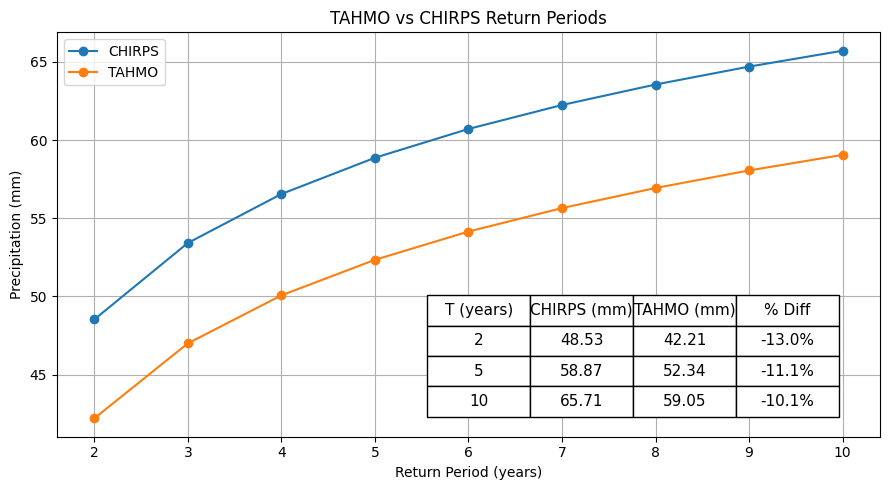

In [18]:
display(selected_rainfall)

# Create a DataFrame for the return periods and rainfall
df_return_periods_chirps = pd.DataFrame({
    'ReturnPeriod': return_periods,
    'Precipitation_mm': selected_rainfall
})
tahmo = pd.read_csv("TA00026.csv")
tahmo['timestamp'] = pd.to_datetime(tahmo['timestamp'], format='%Y-%m-%d')
tahmo.set_index('timestamp', inplace=True)

# Calculate annual maxima for TAHMO
tahmo['year'] = tahmo.index.year
annual_maxima_tahmo = tahmo.groupby('year')['precipitation (mm)'].max().dropna()

# drop the highest value, which is an outlier
ann_max_tahmo_robust = annual_maxima_tahmo.drop(annual_maxima_tahmo.idxmax())  # Adjust threshold as needed
# Fit Gumbel distribution for TAHMO
params_tahmo = stats.gumbel_r.fit(ann_max_tahmo_robust)
#params_tahmo = stats.gumbel_r.fit(annual_maxima_tahmo)
# Calculate quantiles for TAHMO return periods
rainfall_return_levels_tahmo = stats.gumbel_r.ppf(probabilities, *params_tahmo)
# Create a DataFrame for TAHMO return periods and rainfall
df_return_periods_tahmo = pd.DataFrame({
    'ReturnPeriod': return_periods,
    'Precipitation_mm': rainfall_return_levels_tahmo
})

# ...existing code...

# Calculate percentage difference for T=2, 5, 10
compare_T = [2, 5, 10]
summary = []
for T in compare_T:
    tahmo_val = df_return_periods_tahmo[df_return_periods_tahmo['ReturnPeriod'] == T]['Precipitation_mm'].values[0]
    chirps_val = df_return_periods_chirps[df_return_periods_chirps['ReturnPeriod'] == T]['Precipitation_mm'].values[0]
    perc_diff = 100 * (tahmo_val - chirps_val) / chirps_val
    summary.append([T, chirps_val, tahmo_val, perc_diff])

# Create table data
table_data = [
    [f"{row[0]}", f"{row[1]:.2f}", f"{row[2]:.2f}", f"{row[3]:+.1f}%"]
    for row in summary
]
col_labels = ["T (years)", "CHIRPS (mm)", "TAHMO (mm)", "% Diff"]

plt.figure(figsize=(9, 5))
plt.plot(df_return_periods_chirps['ReturnPeriod'], df_return_periods_chirps['Precipitation_mm'], marker='o', label='CHIRPS')
plt.plot(df_return_periods_tahmo['ReturnPeriod'], df_return_periods_tahmo['Precipitation_mm'], marker='o', label='TAHMO')
plt.xlabel('Return Period (years)')
plt.ylabel('Precipitation (mm)')
plt.title('TAHMO vs CHIRPS Return Periods')
plt.legend()
plt.grid()

# Add table to the plot
from matplotlib.patches import Rectangle

ax = plt.gca()
# Add a white rectangle behind the table to hide the grid
rect = Rectangle((0.45, 0.05), 0.5, 0.3, transform=ax.transAxes,
                 color='white', zorder=2, linewidth=0)
ax.add_patch(rect)

the_table = plt.table(
    cellText=table_data,
    colLabels=col_labels,
    loc='lower right',
    cellLoc='center',
    bbox=[0.45, 0.05, 0.5, 0.3],
    zorder=3
)
the_table.auto_set_font_size(False)
the_table.set_fontsize(11)
for key, cell in the_table.get_celld().items():
    cell.set_facecolor('white')
    cell.set_edgecolor('black')
    cell.set_alpha(1.0)

plt.tight_layout()

plt.savefig('tahmo_vs_chirps_return_periods.png', dpi=300, bbox_inches='tight')
plt.show()




Chicago hyetograph for T=2 year (4-hour event, 5-min timestep, total 48.53 mm)
    Station    YY  MM  DD Hour Minute  Chicago_2yr_mm Hour Minute
0      NKT1  2018  05  22   00     00        0.000000   00     00
1      NKT1  2018  05  22   00     05        0.005072   00     05
2      NKT1  2018  05  22   00     10        0.020287   00     10
3      NKT1  2018  05  22   00     15        0.045646   00     15
4      NKT1  2018  05  22   00     20        0.081148   00     20
..      ...   ...  ..  ..  ...    ...             ...  ...    ...
283    NKT1  2018  05  22   23     35        0.000000   23     35
284    NKT1  2018  05  22   23     40        0.000000   23     40
285    NKT1  2018  05  22   23     45        0.000000   23     45
286    NKT1  2018  05  22   23     50        0.000000   23     50
287    NKT1  2018  05  22   23     55        0.000000   23     55

[288 rows x 9 columns]


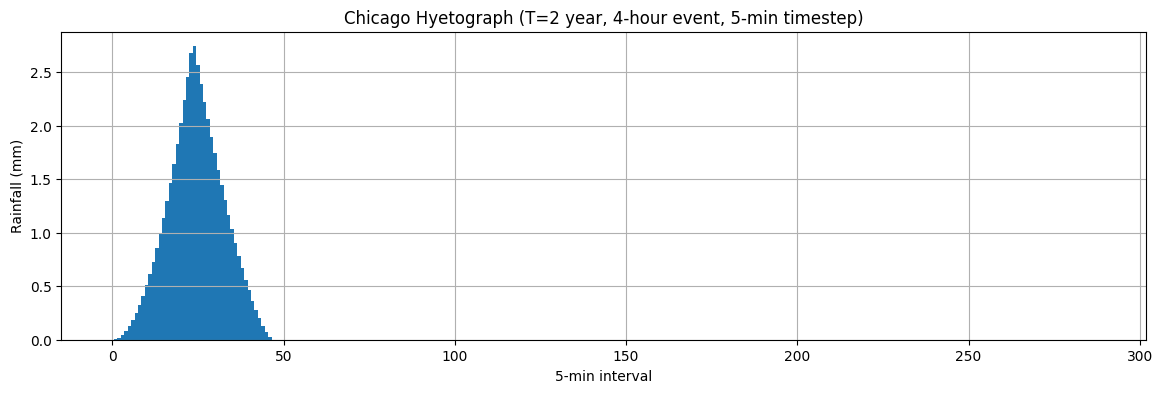


Chicago hyetograph for T=5 year (4-hour event, 5-min timestep, total 58.87 mm)
    Station    YY  MM  DD Hour Minute  Chicago_5yr_mm Hour Minute
0      NKT1  2018  05  22   00     00        0.000000   00     00
1      NKT1  2018  05  22   00     05        0.006152   00     05
2      NKT1  2018  05  22   00     10        0.024608   00     10
3      NKT1  2018  05  22   00     15        0.055368   00     15
4      NKT1  2018  05  22   00     20        0.098432   00     20
..      ...   ...  ..  ..  ...    ...             ...  ...    ...
283    NKT1  2018  05  22   23     35        0.000000   23     35
284    NKT1  2018  05  22   23     40        0.000000   23     40
285    NKT1  2018  05  22   23     45        0.000000   23     45
286    NKT1  2018  05  22   23     50        0.000000   23     50
287    NKT1  2018  05  22   23     55        0.000000   23     55

[288 rows x 9 columns]


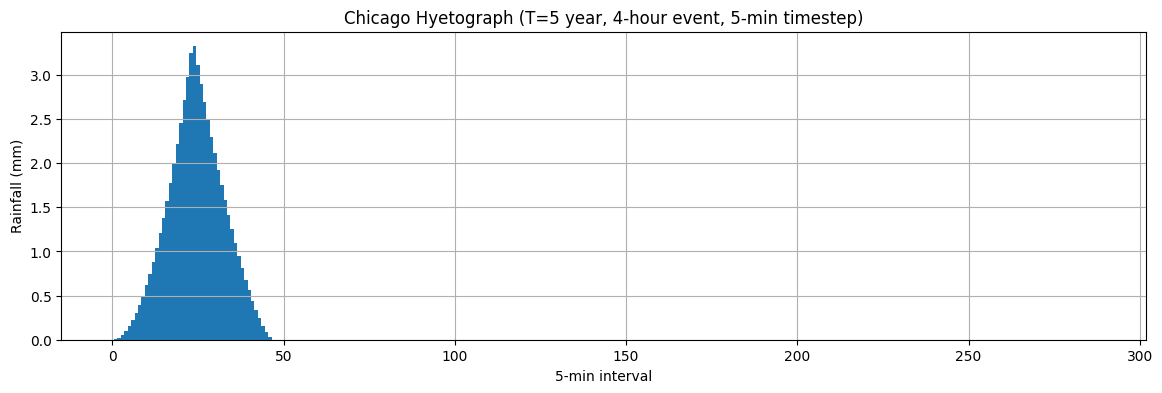


Chicago hyetograph for T=10 year (4-hour event, 5-min timestep, total 65.71 mm)
    Station    YY  MM  DD Hour Minute  Chicago_10yr_mm Hour Minute
0      NKT1  2018  05  22   00     00         0.000000   00     00
1      NKT1  2018  05  22   00     05         0.006867   00     05
2      NKT1  2018  05  22   00     10         0.027469   00     10
3      NKT1  2018  05  22   00     15         0.061805   00     15
4      NKT1  2018  05  22   00     20         0.109875   00     20
..      ...   ...  ..  ..  ...    ...              ...  ...    ...
283    NKT1  2018  05  22   23     35         0.000000   23     35
284    NKT1  2018  05  22   23     40         0.000000   23     40
285    NKT1  2018  05  22   23     45         0.000000   23     45
286    NKT1  2018  05  22   23     50         0.000000   23     50
287    NKT1  2018  05  22   23     55         0.000000   23     55

[288 rows x 9 columns]


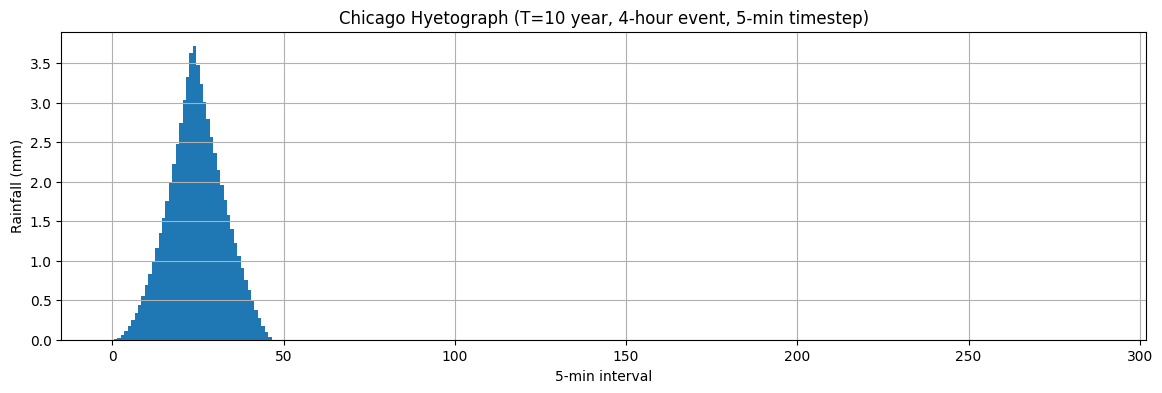

In [21]:

def chicago_hyetograph_nonlinear(total_rain, duration=24, event_length=6, peak_hour=12, exp_rise=2, exp_fall=1.5):
    # steps_per_hour = 12  # for 5-min steps
    # total_steps = duration * steps_per_hour
    # event_steps = event_length * steps_per_hour
    # peak_step = peak_hour * steps_per_hour

    steps_per_hour = 12  # for 5-min steps
    total_steps = duration * steps_per_hour
    event_steps = event_length * steps_per_hour
    peak_step = peak_hour * steps_per_hour

    start = peak_step - event_steps // 2
    end = start + event_steps

    rainfall = np.zeros(total_steps)

    # Nonlinear rising and falling limbs
    rise = np.linspace(0, 1, event_steps // 2 + 1)[:-1] ** exp_rise
    fall = np.linspace(1, 0, event_steps // 2 + 1)[1:] ** exp_fall
    shape = np.concatenate([rise, fall])
    shape /= shape.sum()
    rainfall[start:end] = shape * total_rain

    # Time labels
    time_labels = [f"{h:02d}:{m:02d}" for h in range(duration) for m in range(0, 60, 5)]
    df = pd.DataFrame({'Time': time_labels, 'Rain_mm': rainfall})

    return df

# Example usage:
#df_nonlinear = chicago_hyetograph_nonlinear(50, duration=24, event_length=4, peak_hour=12, exp_rise=2, exp_fall=1.5)

for T, total_rain in zip(selected_T, selected_rainfall):
    df_nonlinear = chicago_hyetograph_nonlinear(
        total_rain, duration=24, event_length=4, peak_hour=2, exp_rise=2, exp_fall=1.5
    )
    df_nonlinear.rename(columns={'Rain_mm': f'Chicago_{T}yr_mm'}, inplace=True)

    # Add year, month, day columns
    df_nonlinear.insert(0, 'Station', 'NKT1')
    df_nonlinear.insert(1, 'YY', '2018')
    df_nonlinear.insert(2, 'MM', '05')
    df_nonlinear.insert(3, 'DD', '22')

     # Split 'Time' into 'Hour' and 'Minute'
    df_nonlinear[['Hour', 'Minute']] = df_nonlinear['Time'].str.split(':', expand=True)
    # Optionally, move Hour and Minute columns after DD
    cols = df_nonlinear.columns.tolist()
    # Remove 'Time', then insert Hour and Minute after 'DD'
    cols.remove('Time')
    hour_idx = cols.index('DD') + 1
    cols = cols[:hour_idx] + ['Hour', 'Minute'] + cols[hour_idx:]
    df_nonlinear = df_nonlinear[cols]

    print(f"\nChicago hyetograph for T={T} year (4-hour event, 5-min timestep, total {total_rain:.2f} mm)")
    print(df_nonlinear)
    # Optional: plot
    plt.figure(figsize=(14, 4))
    plt.bar(np.arange(len(df_nonlinear)), df_nonlinear[f'Chicago_{T}yr_mm'], width=1)
    plt.title(f'Chicago Hyetograph (T={T} year, 4-hour event, 5-min timestep)')
    plt.xlabel('5-min interval')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)


    #df_nonlinear.to_csv(f"chicago_hyetograph_T{T}_year.dat", index=False, header=False, sep='\t', encoding='utf-8')
    plt.show()

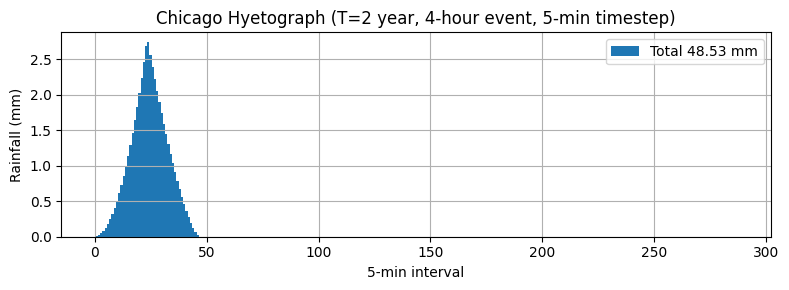

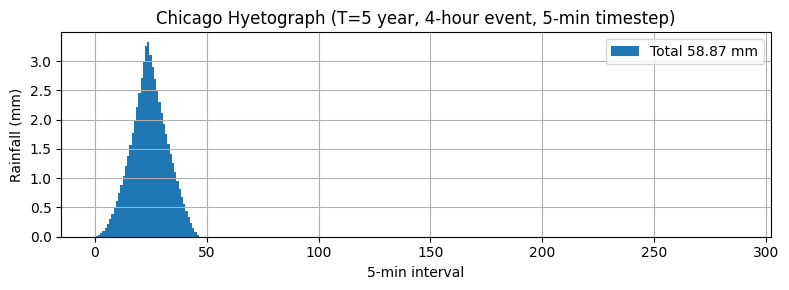

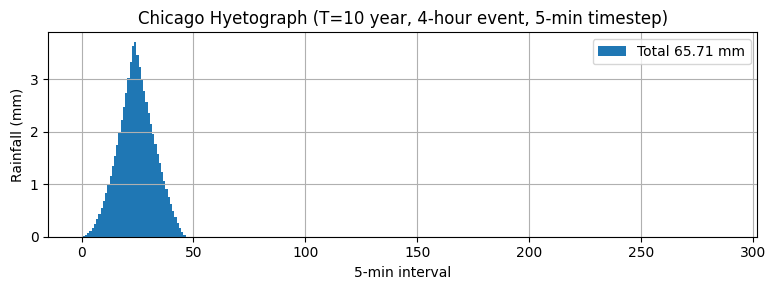

In [22]:
for T, total_rain in zip(selected_T, selected_rainfall):
    df_nonlinear = chicago_hyetograph_nonlinear(
        total_rain, duration=24, event_length=4, peak_hour=2, exp_rise=2, exp_fall=1.5
    )
    df_nonlinear.rename(columns={'Rain_mm': f'Value {T} year'}, inplace=True)

    # Add year, month, day columns
    #df_nonlinear.insert(0, 'Name', '1')
    #df_nonlinear.insert(1, 'Date', '05/22/2018')

    #  # Split 'Time' into 'Hour' and 'Minute'
    # df_nonlinear[['Hour', 'Minute']] = df_nonlinear['Time'].str.split(':', expand=True)
    # # Optionally, move Hour and Minute columns after DD
    # cols = df_nonlinear.columns.tolist()
    # # Remove 'Time', then insert Hour and Minute after 'DD'
    # cols.remove('Time')
    # hour_idx = cols.index('DD') + 1
    # cols = cols[:hour_idx] + ['Hour', 'Minute'] + cols[hour_idx:]
    # df_nonlinear = df_nonlinear[cols]

    # print(f"\nChicago hyetograph for T={T} year (4-hour event, 5-min timestep, total {total_rain:.2f} mm):")
    #print(df_nonlinear)
    # Optional: plot
    plt.figure(figsize=(8, 3))
    plt.bar(np.arange(len(df_nonlinear)), df_nonlinear[f'Value {T} year'], width=1, label=f'Total {total_rain:.2f} mm')
    plt.legend()
    plt.title(f'Chicago Hyetograph (T={T} year, 4-hour event, 5-min timestep)')
    plt.xlabel('5-min interval')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"chicago_hyetograph_T{T}_year.png", dpi=300)


    df_nonlinear.to_csv(f"timeseries_chicago_hyetograph_T{T}_year.dat", index=False, header=False, sep='\t', encoding='utf-8')
    plt.show()

In [12]:
def chicago_hyetograph_nonlinear(
    total_rain, duration=24, event_length=6, peak_hour=12, exp_rise=2, exp_fall=1.5,
    station='NKT1', year='2018', month='05', day='22'
):
    """
    Non-linear Chicago hyetograph with 5-min timestep and split time columns.
    """
    steps_per_hour = 12  # 5-min steps
    total_steps = duration * steps_per_hour
    event_steps = event_length * steps_per_hour
    peak_step = peak_hour * steps_per_hour

    start = peak_step - event_steps // 2
    end = start + event_steps

    rainfall = np.zeros(total_steps)
    # Nonlinear rising and falling limbs
    rise = np.linspace(0, 1, event_steps // 2 + 1)[:-1] ** exp_rise
    fall = np.linspace(1, 0, event_steps // 2 + 1)[1:] ** exp_fall
    shape = np.concatenate([rise, fall])
    shape /= shape.sum()
    rainfall[start:end] = shape * total_rain

    # Time labels and split into hour/minute
    time_labels = [f"{h:02d}:{m:02d}" for h in range(duration) for m in range(0, 60, 5)]
    hours = [label.split(':')[0] for label in time_labels]
    minutes = [label.split(':')[1] for label in time_labels]

    df = pd.DataFrame({
        'Station': station,
        'YY': year,
        'MM': month,
        'DD': day,
        'Hour': hours,
        'Minute': minutes,
        'Rain_mm': rainfall
    })
    print(f"Total rain (should match input): {df['Rain_mm'].sum():.4f} mm")
    return df

# Example usage:
for T, total_rain in zip(selected_T, selected_rainfall):
    df_nonlinear = chicago_hyetograph_nonlinear(
        total_rain, duration=24, event_length=4, peak_hour=2, exp_rise=2, exp_fall=1.5,
        station='NKT1', year='2018', month='05', day='22'
    )
    df_nonlinear.rename(columns={'Rain_mm': f'Chicago_{T}yr_mm'}, inplace=True)
    print(df_nonlinear)
    # Save or plot as needed

Total rain (should match input): 56.2436 mm
    Station    YY  MM  DD Hour Minute  Chicago_2yr_mm
0      NKT1  2018  05  22   00     00        0.000000
1      NKT1  2018  05  22   00     05        0.005878
2      NKT1  2018  05  22   00     10        0.023512
3      NKT1  2018  05  22   00     15        0.052902
4      NKT1  2018  05  22   00     20        0.094048
..      ...   ...  ..  ..  ...    ...             ...
283    NKT1  2018  05  22   23     35        0.000000
284    NKT1  2018  05  22   23     40        0.000000
285    NKT1  2018  05  22   23     45        0.000000
286    NKT1  2018  05  22   23     50        0.000000
287    NKT1  2018  05  22   23     55        0.000000

[288 rows x 7 columns]
Total rain (should match input): 64.1800 mm
    Station    YY  MM  DD Hour Minute  Chicago_5yr_mm
0      NKT1  2018  05  22   00     00        0.000000
1      NKT1  2018  05  22   00     05        0.006707
2      NKT1  2018  05  22   00     10        0.026830
3      NKT1  2018  05  2